<a href="https://colab.research.google.com/github/khangnkv/UniversityProjects/blob/main/FITR_Microplastic_Denoise_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *** Set Up Here! ***

In [ ]:
# List of substnaces
NameList = ["Acrylic", "Cellulose", "ENR", "EPDM", "HDPE", "LDPE", "Nylon", "PBAT", "PBS", "PC", \
             "PEEK", "PEI", "PET", "PLA", "PMMA", "POM", "PP", "PS", "PTEE", "PU", "PVA", "PVC"]

# Save NumPy array
NumPyPath = '/content/gdrive/My Drive/DeNoise/DeNoise Dataset/'


# Python Package Installation

In [ ]:
import os

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)


# Check if a package is already installed and install it if not
def install_package(package_name):
    try:
        __import__(package_name)  # Attempt to import the package
    except ImportError:
        print(f"Installing {package_name}...")
        !pip install {package_name}
        print(f"{package_name} is installed.")
    else:
        print(f"{package_name} is already installed.")

# Install Python 3.11 if not already installed
try:
    !python3.11 --version
except:
    print("Installing Python 3.11...")
    !apt-get install python3.11
    print("Python 3.11 is installed.")
else:
    print("Python 3.11 is already installed.")

# Install required packages only if they are not installed
install_package("scikit-plot")
install_package("pybaselines")

# Upgrade TensorFlow if not already up to date
try:
    import tensorflow
    current_version = tensorflow.__version__
except ImportError:
    current_version = None

if current_version is None or current_version < "2.0":
    print("Upgrading TensorFlow...")
    !pip install --upgrade tensorflow
    print("TensorFlow is upgraded.")
else:
    print(f"TensorFlow {current_version} is already installed and up to date.")


Mounted at /content/gdrive
/bin/bash: line 1: python3.11: command not found
Python 3.11 is already installed.
Installing scikit-plot...
scikit-plot is installed.
Installing pybaselines...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 3.2 MB/s eta 0:00:00
pybaselines is installed.
TensorFlow 2.14.0 is already installed and up to date.


# Load Library

In [ ]:
from __future__ import print_function
from matplotlib import pyplot as plt
#matplotlib inline
import numpy as np
from numpy import save, load
import pandas as pd
import random
import seaborn as sns
import scipy as sp
import statistics
import scikitplot as skplt
from scipy.io import loadmat
from scipy import stats
from scipy.stats import moment
from IPython.display import display, HTML
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif, f_regression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report
plt.style.use('bmh') # for better plots

# Classifiers
#Classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#Neural networks
from sklearn.neural_network import MLPClassifier

#Ensemble methods
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost

import tensorflow as tf
import keras
from keras.layers import Input
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation, Add, ZeroPadding1D, ZeroPadding2D, GlobalAveragePooling1D
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AveragePooling1D, AveragePooling2D, BatchNormalization, Conv1DTranspose
from keras.layers import LSTM, TimeDistributed, Bidirectional, GRU, ConvLSTM2D, SeparableConv1D
from keras.layers import Concatenate, GlobalMaxPooling1D
from keras.utils import to_categorical
from keras import backend as K
from keras.initializers import glorot_uniform

from keras.applications import imagenet_utils
from keras import backend
#from keras.utils import data_utils
#from keras.utils import layer_utils

from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Conv1D, SimpleRNN
from tensorflow.keras.models import Model
from keras.layers import Add, Subtract, Maximum, Average, Minimum, Concatenate, Multiply, Dot

import pybaselines
import os
import random as rd
from scipy import interpolate
from scipy.optimize import least_squares
from scipy import ndimage

import time
#import spectrochempy as scp

from sklearn.decomposition import NMF, DictionaryLearning
from sklearn.metrics import mean_squared_error
import math

# 0 Basic Functions

In [ ]:
# Preferred wavenumber range and resolution
WaveRef =np.arange(700, 3950, 0.5)

def BaseLineCorrection(Spec):
  BLine = pybaselines.polynomial.imodpoly(Spec, poly_order=6)[0]
  Spec_BC = Spec - BLine
  return Spec_BC

def SpecInterpolation(WaveOrigin, Spec, WaveRef):
  Spec_Inter = interpolate.interp1d(WaveOrigin, Spec)
  Spec_New = Spec_Inter(WaveRef)
  return Spec_New

def MinMaxNorm(Spec):
  S_Max = max(Spec)
  S_Min = min(Spec)
  Spec_Norm = (Spec - S_Min)/(S_Max-S_Min)
  return Spec_Norm

def CsvToSpec(PathName, DirName, FileName):
  df = pd.read_csv(PathName+DirName+'/'+FileName, sep=',', header=None, encoding= 'unicode_escape')
  dfSort = df.sort_values(df.columns[0])
  Spec = np.array(dfSort[dfSort.columns[1]])
  Wave = np.array(dfSort[dfSort.columns[0]])
  SpecInter = SpecInterpolation(Wave, Spec, WaveRef)
  SpecBC = BaseLineCorrection(SpecInter)
  SpecNorm = MinMaxNorm(SpecBC)
  return SpecInter, SpecBC, SpecNorm

# 0 Denoising DL Models

In [ ]:
BatchSize = 64
NumEpochs = 30
InputLength = len(WaveRef)
#print(x_train.shape[1])

# 1. AutoEncoder
def AEModel(visible):
  x = Dense(512, activation=tf.keras.layers.LeakyReLU())(visible)
  x = Dense(256, activation=tf.keras.layers.LeakyReLU())(x)
  x = Dense(32, activation=tf.keras.layers.LeakyReLU())(x)
  x = Dense(256, activation=tf.keras.layers.LeakyReLU())(x)
  x = Dense(512, activation=tf.keras.layers.LeakyReLU())(x)
  x = Dense(InputLength, activation="tanh")(x)
  return x


# 2. CNN AutoEncoder
def CnnAEModel(visible):
  # Encoder
  x = Conv1D(64, kernel_size=9, padding="same")(visible)
  x = Conv1D(64, kernel_size=9, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling1D(pool_size=9, strides=5, padding='same')(x)
  x = Conv1D(128, kernel_size=9, padding="same")(x)
  x = Conv1D(128, kernel_size=9, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling1D(pool_size=9, strides=5, padding='same')(x)
  x = Conv1D(256, kernel_size=9, padding="same")(x)
  x = Conv1D(256, kernel_size=9, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling1D(pool_size=9, strides=4, padding='same')(x)
  # Decoder
  x = Conv1DTranspose(256,kernel_size=9, strides=4, padding="same")(x)
  x = Activation("relu")(x)
  x = Conv1DTranspose(128,kernel_size=9, strides=5, padding="same")(x)
  x = Activation("relu")(x)
  x = Conv1DTranspose(64,kernel_size=9, strides=5, padding="same")(x)
  x = Activation("relu")(x)
  x = Conv1D(1, kernel_size=9, padding="same", activation="tanh")(x)
  return x


# 3. UNet
#def UNetModel(x, n_filters_list = [32, 64, 128, 256]):
def UNetModel(x, n_filters_list = [64, 128, 256]):
  contraction = {}
  # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
  for f in n_filters_list:
    x = Conv1D(f, 5, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = Dropout(0.1)(x)
    x = Conv1D(f, 5, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    print("Encoder: ",x)
    contraction[f'conv{f}'] = x
    x = MaxPooling1D(pool_size=4,strides=2, padding='same')(x)

  x = Conv1D(200, 5, activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = Dropout(0.2)(x)
  x = Conv1D(200, 5, activation='relu', kernel_initializer='he_normal', padding='same')(x)

  # Expansive path: Second half of the network: upsampling inputs
  for i,f in zip([0,0,0,0],reversed(n_filters_list)):
    x = Conv1DTranspose(f, 4 + i, 2, padding='same')(x)
    #print(x.shape)
    print("Decoder: ",x)
    print(contraction[f'conv{f}'].shape)
    x = Concatenate(axis=2)([x, contraction[f'conv{f}']])
    x = Conv1D(f, 5, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv1D(f, 5, activation='relu', kernel_initializer='he_normal', padding='same')(x)

  x = Conv1D(filters=1, kernel_size=3, activation="tanh", padding="same")(x)
  return x


import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def create_custom_sequential_model(input_shape):

    x = Dense(256, activation='relu')(input_shape)  # Reduced from 2048 to 256
    x = Dense(128, activation='relu')(x)          # Reduced from 1024 to 128
    x = Dense(64, activation='relu')(x)           # Reduced from 1024 to 64
    x = Dense(32, activation='relu')(x)           # Reduced from 128 to 32
    output = Dense(2, activation='softmax')(x)
    return output


def get_model(input_shape):
    image = tf.keras.layers.Input(shape=input_shape)
    theta = Localization()(image)
    x = BilinearInterpolation(height=input_shape[0], width=input_shape[1])([image, theta])
    x = tf.keras.layers.Conv2D(64, [9, 9], activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, [7, 7], activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    return x


In [ ]:
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, AveragePooling1D, Add, Concatenate
import numpy as np

def CBDNet(input_tensor):
    x = Conv1D(32, 3, activation="relu", kernel_initializer='he_normal', padding="same")(input_tensor)
    x = Conv1D(32, 3, activation="relu", kernel_initializer='he_normal', padding="same")(x)
    x = Conv1D(32, 3, activation="relu", kernel_initializer='he_normal', padding="same")(x)
    x = Conv1D(32, 3, activation="relu", kernel_initializer='he_normal', padding="same")(x)
    x = Conv1D(3, 3, activation="relu", kernel_initializer='he_normal', padding="same")(x)

    # Non Blind denoising subnetwork
    x = Concatenate()([x, input_tensor])
    conv1 = Conv1D(64, 3, activation="relu", kernel_initializer='he_normal', padding="same")(x)
    conv2 = Conv1D(64, 3, activation="relu", kernel_initializer='he_normal', padding="same")(conv1)

    pool1 = AveragePooling1D(pool_size=2, padding='same')(conv2)
    conv3 = Conv1D(128, 3, activation="relu", kernel_initializer='he_normal', padding="same")(pool1)
    conv4 = Conv1D(128, 3, activation="relu", kernel_initializer='he_normal', padding="same")(conv3)
    conv5 = Conv1D(128, 3, activation="relu", kernel_initializer='he_normal', padding="same")(conv4)

    pool2 = AveragePooling1D(pool_size=2, padding='same')(conv5)
    conv6 = Conv1D(256, 3, activation="relu", kernel_initializer='he_normal', padding="same")(pool2)
    conv7 = Conv1D(256, 3, activation="relu", kernel_initializer='he_normal', padding="same")(conv6)
    conv8 = Conv1D(256, 3, activation="relu", kernel_initializer='he_normal', padding="same")(conv7)
    conv9 = Conv1D(256, 3, activation="relu", kernel_initializer='he_normal', padding="same")(conv8)
    conv10 = Conv1D(256, 3, activation="relu", kernel_initializer='he_normal', padding="same")(conv9)
    conv11 = Conv1D(256, 3, activation="relu", kernel_initializer='he_normal', padding="same")(conv10)

    upsample1 = Conv1DTranspose(128, 3, strides=2, activation="relu", kernel_initializer='he_normal', padding="same")(conv11)
    add1 = Add()([upsample1, conv5])
    conv12 = Conv1D(128, 3, activation="relu", kernel_initializer='he_normal', padding="same")(add1)
    conv13 = Conv1D(128, 3, activation="relu", kernel_initializer='he_normal', padding="same")(conv12)
    conv14 = Conv1D(128, 3, activation="relu", kernel_initializer='he_normal', padding="same")(conv13)

    upsample2 = Conv1DTranspose(64, 3, strides=2, activation="relu", kernel_initializer='he_normal', padding="same")(conv14)
    add1 = Add()([upsample2, conv2])
    conv15 = Conv1D(64, 3, activation="relu", kernel_initializer='he_normal', padding="same")(add1)
    conv16 = Conv1D(64, 3, activation="relu", kernel_initializer='he_normal', padding="same")(conv15)

    out = Conv1D(3, 1, kernel_initializer='he_normal', padding="same")(conv16)
    out = Add()([out, input_tensor])
    return out



In [ ]:
def DAE(input_shape):
    latent_dim = 128

    # Encoder
    inputs = Input(shape=input_shape)
    x = Conv1D(32, kernel_size=3, strides=2, activation='relu', padding='same')(inputs)
    x = Conv1D(64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    latent_repr = Dense(latent_dim)(x)

    # Decoder
    x = Dense(7 * 64)(latent_repr)
    x = Reshape((7, 64))(x)
    x = Conv1DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    decoded = Conv1DTranspose(1, kernel_size=3, strides=2, activation='sigmoid', padding='same')(x)
    return decoded


In [ ]:
def dae(input_shape, n_inputs):
#--- Encoder Layer
  e = Dense(units=n_inputs, name='Encoder-Layer')(input_shape)
  e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
  e = tf.keras.layers.LeakyReLU(name='Encoder-Layer-Activation')(e)

#--- Middle Layer
  middle = Dense(units=n_inputs, activation='linear', activity_regularizer=keras.regularizers.L1(0.0001), name='Middle-Hidden-Layer')(e)

#--- Decoder Layer
  d = Dense(units=n_inputs, name='Decoder-Layer')(middle)
  d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
  d = tf.keras.layers.LeakyReLU(name='Decoder-Layer-Activation')(d)

#--- Output layer
  output = Dense(units=n_inputs, activation='tanh', name='Output-Layer')(d)
  return output

# 1 Load Dataset

In [ ]:
from __future__ import print_function
from matplotlib import pyplot as plt
#matplotlib inline
import numpy as np
from numpy import save, load
import pandas as pd
import random
import seaborn as sns
import scipy as sp
import statistics
import scikitplot as skplt
from scipy.io import loadmat
from scipy import stats
from scipy.stats import moment
from IPython.display import display, HTML
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif, f_regression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report
plt.style.use('bmh') # for better plots

# Classifiers
#Classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#Neural networks
from sklearn.neural_network import MLPClassifier

#Ensemble methods
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost

import tensorflow as tf
import keras
from keras.layers import Input
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation, Add, ZeroPadding1D, ZeroPadding2D, GlobalAveragePooling1D
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AveragePooling1D, AveragePooling2D, BatchNormalization, Conv1DTranspose
from keras.layers import LSTM, TimeDistributed, Bidirectional, GRU, ConvLSTM2D, SeparableConv1D
from keras.layers import Concatenate, GlobalMaxPooling1D
from keras.utils import to_categorical
from keras import backend as K
from keras.initializers import glorot_uniform

from keras.applications import imagenet_utils
from keras import backend
#from keras.utils import data_utils
#from keras.utils import layer_utils

from keras.layers import Add, Subtract, Maximum, Average, Minimum, Concatenate, Multiply, Dot

import pybaselines
import os
import random as rd
from scipy import interpolate
from scipy.optimize import least_squares
from scipy import ndimage

import time
#import spectrochempy as scp

from sklearn.decomposition import NMF, DictionaryLearning
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf

# **0 Basic Function**

In [ ]:
# Preferred wavenumber range and resolution
WaveRef =np.arange(700, 3950, 0.5)

def BaseLineCorrection(Spec):
  BLine = pybaselines.polynomial.imodpoly(Spec, poly_order=6)[0]
  Spec_BC = Spec - BLine
  return Spec_BC

def SpecInterpolation(WaveOrigin, Spec, WaveRef):
  Spec_Inter = interpolate.interp1d(WaveOrigin, Spec)
  Spec_New = Spec_Inter(WaveRef)
  return Spec_New

def MinMaxNorm(Spec):
  S_Max = max(Spec)
  S_Min = min(Spec)
  Spec_Norm = (Spec - S_Min)/(S_Max-S_Min)
  return Spec_Norm

def CsvToSpec(PathName, DirName, FileName):
  df = pd.read_csv(PathName+DirName+'/'+FileName, sep=',', header=None, encoding= 'unicode_escape')
  dfSort = df.sort_values(df.columns[0])
  Spec = np.array(dfSort[dfSort.columns[1]])
  Wave = np.array(dfSort[dfSort.columns[0]])
  SpecInter = SpecInterpolation(Wave, Spec, WaveRef)
  SpecBC = BaseLineCorrection(SpecInter)
  SpecNorm = MinMaxNorm(SpecBC)
  return SpecInter, SpecBC, SpecNorm

# **0 Denoising Model**

In [ ]:
BatchSize = 32
NumEpochs = 50
InputLength = len(WaveRef)
#print(x_train.shape[1])

# 1. AutoEncoder
def AEModel(visible):
  x = Dense(512, activation=tf.keras.layers.LeakyReLU())(visible)
  x = Dense(256, activation=tf.keras.layers.LeakyReLU())(x)
  x = Dense(32, activation=tf.keras.layers.LeakyReLU())(x)
  x = Dense(256, activation=tf.keras.layers.LeakyReLU())(x)
  x = Dense(512, activation=tf.keras.layers.LeakyReLU())(x)
  x = Dense(InputLength, activation="tanh")(x)
  return x


# 2. CNN AutoEncoder
def CnnAEModel(visible):
  # Encoder
  x = Conv1D(64, kernel_size=9, padding="same")(visible)
  x = Conv1D(64, kernel_size=9, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling1D(pool_size=9, strides=5, padding='same')(x)
  x = Conv1D(128, kernel_size=9, padding="same")(x)
  x = Conv1D(128, kernel_size=9, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling1D(pool_size=9, strides=5, padding='same')(x)
  x = Conv1D(256, kernel_size=9, padding="same")(x)
  x = Conv1D(256, kernel_size=9, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling1D(pool_size=9, strides=4, padding='same')(x)
  # Decoder
  x = Conv1DTranspose(256,kernel_size=9, strides=4, padding="same")(x)
  x = Activation("relu")(x)
  x = Conv1DTranspose(128,kernel_size=9, strides=5, padding="same")(x)
  x = Activation("relu")(x)
  x = Conv1DTranspose(64,kernel_size=9, strides=5, padding="same")(x)
  x = Activation("relu")(x)
  x = Conv1D(1, kernel_size=9, padding="same", activation="tanh")(x)
  return x


# 3. UNet
#def UNetModel(x, n_filters_list = [32, 64, 128, 256]):
def UNetModel(x, n_filters_list = [64, 128, 256]):
  contraction = {}
  # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
  for f in n_filters_list:
    x = Conv1D(f, 5, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = Dropout(0.1)(x)
    x = Conv1D(f, 5, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    print("Encoder: ",x)
    contraction[f'conv{f}'] = x
    x = MaxPooling1D(pool_size=4,strides=2, padding='same')(x)

  x = Conv1D(200, 5, activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = Dropout(0.2)(x)
  x = Conv1D(200, 5, activation='relu', kernel_initializer='he_normal', padding='same')(x)

  # Expansive path: Second half of the network: upsampling inputs
  for i,f in zip([0,0,0,0],reversed(n_filters_list)):
    x = Conv1DTranspose(f, 4 + i, 2, padding='same')(x)
    #print(x.shape)
    print("Decoder: ",x)
    print(contraction[f'conv{f}'].shape)
    x = Concatenate(axis=2)([x, contraction[f'conv{f}']])
    x = Conv1D(f, 5, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv1D(f, 5, activation='relu', kernel_initializer='he_normal', padding='same')(x)

  x = Conv1D(filters=1, kernel_size=3, activation="tanh", padding="same")(x)
  return x


import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def create_custom_sequential_model(input_shape):

    x = Dense(256, activation='relu')(input_shape)  # Reduced from 2048 to 256
    x = Dense(128, activation='relu')(x)          # Reduced from 1024 to 128
    x = Dense(64, activation='relu')(x)           # Reduced from 1024 to 64
    x = Dense(32, activation='relu')(x)           # Reduced from 128 to 32
    output = Dense(2, activation='softmax')(x)
    return output


def get_model(input_shape):
    image = tf.keras.layers.Input(shape=input_shape)
    theta = Localization()(image)
    x = BilinearInterpolation(height=input_shape[0], width=input_shape[1])([image, theta])
    x = tf.keras.layers.Conv2D(64, [9, 9], activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, [7, 7], activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    return x


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
def rnn(input_shape, rnn_units):
    # Define the input layer with the specified input shape
    visible = Input(shape=input_shape)

    # Create an RNN model using SimpleRNN layers
    x = SimpleRNN(rnn_units, return_sequences=True)(visible)  # You can adjust the number of units as needed
    x = SimpleRNN(rnn_units)(x)
    output = Dense(units = 1, activation='softmax')(x)  # Adjust the number of output units

    model = Model(inputs=visible, outputs=output)

    return output  # Return the output tensor


In [ ]:
'''
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming your data is loaded and stored in variables X_train and y_train
# X_train: input data with shape (2200, 6500)
# y_train: corresponding clean spectra with shape (2200, 6500)

# Define the model
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(6500,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6500, activation='linear'))  # Output layer with linear activation for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict using the trained model
y_pred = model.predict(X_test)
'''

"\nimport tensorflow as tf\nfrom tensorflow.keras import layers, models\n\n# Assuming your data is loaded and stored in variables X_train and y_train\n# X_train: input data with shape (2200, 6500)\n# y_train: corresponding clean spectra with shape (2200, 6500)\n\n# Define the model\nmodel = models.Sequential()\nmodel.add(layers.Dense(128, activation='relu', input_shape=(6500,)))\nmodel.add(layers.Dense(64, activation='relu'))\nmodel.add(layers.Dense(6500, activation='linear'))  # Output layer with linear activation for regression\n\n# Compile the model\nmodel.compile(optimizer='adam', loss='mean_squared_error')\n\n# Train the model\nmodel.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)\n\n# Predict using the trained model\ny_pred = model.predict(X_test)\n"

In [ ]:
def rnn(input_shape):
    # Initializing the ANN
    rnn = Sequential()

    # Add the input layer and first hidden layer
    rnn.add(LSTM(units=45, return_sequences=True, input_shape=(input_shape.shape[1], 1))) #change input shape because the makes no sense for shape
    rnn.add(Dropout(0.2))

    rnn.add(LSTM(units=45, return_sequences=True))
    rnn.add(Dropout(0.2))

    rnn.add(LSTM(units=45, return_sequences=True))
    rnn.add(Dropout(0.2))

    rnn.add(LSTM(units=45))
    rnn.add(Dropout(0.2))

    rnn.add(Dense(units=1))

    return rnn


In [ ]:
def dae(input_shape, n_inputs):
#--- Encoder Layer
  e = Dense(units=n_inputs, name='Encoder-Layer')(input_shape)
  e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
  e = tf.keras.layers.LeakyReLU(name='Encoder-Layer-Activation')(e)

#--- Middle Layer
  middle = Dense(units=n_inputs, activation='linear', activity_regularizer=keras.regularizers.L1(0.0001), name='Middle-Hidden-Layer')(e)

#--- Decoder Layer
  d = Dense(units=n_inputs, name='Decoder-Layer')(middle)
  d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
  d = tf.keras.layers.LeakyReLU(name='Decoder-Layer-Activation')(d)

#--- Output layer
  output = Dense(units=n_inputs, activation='tanh', name='Output-Layer')(d)
  return output

In [ ]:
def deep_rnn(input_shape):
    # Initializing the deep RNN
    deep_rnn = Sequential()

    # Add the input layer and the first LSTM layer
    deep_rnn.add(LSTM(units=64, return_sequences=True, input_shape=(input_shape.shape[1], 1)))
    deep_rnn.add(Dropout(0.2))

    # Add additional LSTM layers
    for _ in range(9):  # 10 layers in total, subtracting the first layer
        deep_rnn.add(LSTM(units=45, return_sequences=True))
        deep_rnn.add(Dropout(0.2))

    # Add the final LSTM layer without returning sequences
    deep_rnn.add(LSTM(units=45))
    deep_rnn.add(Dropout(0.2))

    # Add a Dense layer for output
    deep_rnn.add(Dense(units=1))

    return deep_rnn

# **1 Load Dataset**

In [ ]:
SynCleanSet = load(NumPyPath+'SynCleanSet.npy')
SynMFSet = load(NumPyPath+'SynMFSet.npy')

TrainCleanSpecSet = load(NumPyPath+'TrainCleanSet.npy')
TrainNoisySet_0SNR = load(NumPyPath+'TrainNoisySet_0SNR.npy')
#TrainNoisySet_10SNR = load(NumPyPath+'TrainNoisySet_10SNR.npy')
TrainNoisySet_20SNR = load(NumPyPath+'TrainNoisySet_20SNR.npy')
TrainNoisySet_30SNR = load(NumPyPath+'TrainNoisySet_30SNR.npy')
TrainNoisySet_40SNR = load(NumPyPath+'TrainNoisySet_40SNR.npy')

TestCleanSpecSet = load(NumPyPath+'TestCleanSet.npy')
TestNoisySet_0SNR = load(NumPyPath+'TestNoisySet_0SNR.npy')
TestNoisySet_10SNR = load(NumPyPath+'TestNoisySet_10SNR.npy')
TestNoisySet_20SNR = load(NumPyPath+'TestNoisySet_20SNR.npy')
TestNoisySet_30SNR = load(NumPyPath+'TestNoisySet_30SNR.npy')
TestNoisySet_40SNR = load(NumPyPath+'TestNoisySet_40SNR.npy')

print(SynCleanSet.shape)
print(SynMFSet.shape)
print(TestCleanSpecSet.shape)
print(TestNoisySet_0SNR.shape)

# Create sy
NumSample = 100
n=0
for i in NameList:
  act = n*np.ones(NumSample,)
  if (n==0):
    sy = act
  else:
    sy = np.append(sy, act, axis=0)
  n = n+1

NumSynClean = 100
NumCleanSpec =10

(2200, 6500)
(200, 6500)
(2200, 6500)
(2200, 6500)


Pearson Correlation

In [ ]:
from sklearn.preprocessing import StandardScaler
TrainClean = TrainCleanSpecSet[:, 0:6496]
TrainNoisy = TrainNoisySet_0SNR[:, 0:6496]
TestCleanSet = TestCleanSpecSet[:, 0:6496]
TestNoisySet = TestNoisySet_0SNR[:, 0:6496]

print(TrainClean.shape)
print(TrainNoisy.shape)
print(TestCleanSet.shape)
print(TestNoisySet.shape)
TrainCleanSet =  np.array(TrainClean.reshape((TrainClean.shape[0], TrainClean.shape[1])))

TrainNoisySet = TrainNoisy.reshape((TrainNoisy.shape[0], TrainNoisy.shape[1]))
# 1. Traing the denosing Model
n_inputs = TrainNoisySet.shape[1]
visible = Input(shape=(TrainNoisySet.shape[1]))
rnn_units = 45
output = dae(visible, n_inputs)
#output = rnn(TrainCleanSet, rnn_units)



model = Model(inputs=visible, outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
history = model.fit(TrainNoisySet, TrainCleanSet, epochs=NumEpochs, batch_size=BatchSize)

# 2. Creating a denoised spectral dataset
for n in range(0, len(TestNoisySet), 1):
  DenSpec = model.predict(TestNoisySet[n,:].reshape(1, TestNoisySet.shape[1]))
  DenSpecNorm = MinMaxNorm(DenSpec.reshape(DenSpec.shape[1],))
  if (n==0):
    DenSpecSet = DenSpecNorm.reshape(1, DenSpecNorm.shape[0])
  else:
    DenSpecSet = np.append(DenSpecSet, DenSpecNorm.reshape(1, DenSpecNorm.shape[0]), axis=0)

Corr = 0
for k in range(0, DenSpecSet.shape[0], 1):
  if (max(DenSpecSet[k,:])-min(DenSpecSet[k,:])==0):
    cor_ef = 0
  else:
    Grad_Clean = np.gradient(TestCleanSet[k,:])
    Grad_Noisy = np.gradient(DenSpecSet[k,:])
    cor_ef = np.corrcoef(Grad_Clean, Grad_Noisy)
  Corr = Corr + cor_ef
AveCorr = Corr/DenSpecSet.shape[0]
print(AveCorr)
#print('NumZeroSpec: ', NumZeroSpec)


(2200, 6496)
(2200, 6496)
(2200, 6496)
(2200, 6496)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6496)]            0         
                                                                 
 Encoder-Layer (Dense)       (None, 6496)              42204512  
                                                                 
 Encoder-Layer-Normalizatio  (None, 6496)              25984     
 n (BatchNormalization)                                          
                                                                 
 Encoder-Layer-Activation (  (None, 6496)              0         
 LeakyReLU)                                                      
                                                                 
 Middle-Hidden-Layer (Dense  (None, 6496)              42204512  
 )                                                               
       

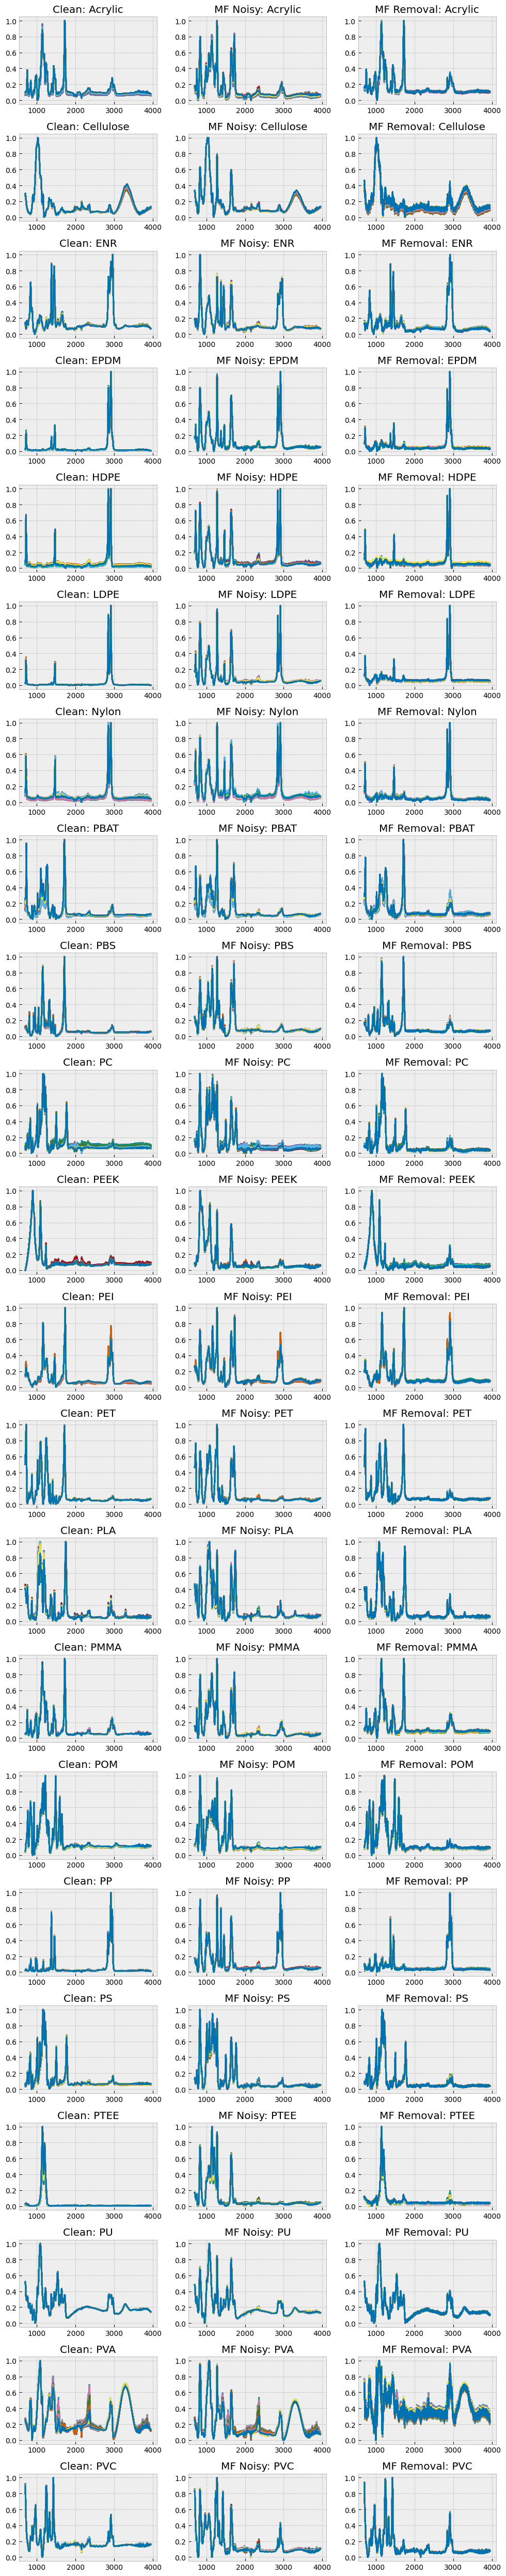

In [ ]:
n=0
fig, axs = plt.subplots(22, 3, figsize=(10,50))
for i in NameList:
  #fig, axs = plt.subplots(1, 2, figsize=(7,5))
  for k in range(0, NumSample, 1):
    axs[n,0].plot(WaveRef[0:6496], TestCleanSet[NumSample*n+k,:], '-')# put in WaveRef[0:6496] for all loops
  plt.grid(True)
  axs[n,0].set_title("Clean: "+i)
  for k in range(0, NumSample, 1):
    axs[n,1].plot(WaveRef[0:6496], TestNoisySet[NumSample*n+k,:], '-')
  plt.grid(True)
  axs[n,1].set_title("MF Noisy: "+i)
  for k in range(0, NumSample, 1):
    axs[n,2].plot(WaveRef[0:6496], DenSpecSet[NumSample*n+k,:], '-')
  plt.grid(True)
  axs[n,2].set_title("MF Removal: "+i)
  #fig.tight_layout()
  n = n+1
fig.tight_layout()

In [ ]:
TestNoisyReconNorm = DenSpecSet

CorrAll = 0
NumZeroSpec = 0
y_predict = []
for m in range(0, TestNoisyReconNorm.shape[0], 1):
  n = -1
  CorrSet = []
  for i in NameList:
    n = n+1
    SubSynCleanSet = SynCleanSet[n*NumSynClean:n*NumSynClean+NumCleanSpec]
    Corr = 0
    AveCorr = 0
    for k in range(0, NumCleanSpec, 1):
      if (max(TestNoisyReconNorm[m,:])-min(TestNoisyReconNorm[m,:])==0):
        cor_ef = 0
        Corr = Corr + cor_ef
      else:
        Grad_Clean = np.gradient(SubSynCleanSet[k,:])
        Grad_Noisy = np.gradient(TestNoisyReconNorm[m,:])
        cor_ef = np.corrcoef(Grad_Clean[0:6496], Grad_Noisy[0:6496])
        Corr = Corr + cor_ef[0,1]
    AveCorr = Corr/NumCleanSpec
    #AveCorrNum = float(AveCorr[0,1])
    CorrSet.append(AveCorr)


    #print(AveCorr.shape)
    #print(AveCorr[0][1])
    #CorrSet.append(AveCorr[0][1])
    #if (n==0):
    #  CorrSet = AveCorr[0][1]
    #  CorrSet = CorrSet.reshape(1,1)
    #else:
    #  CorrSet = np.append(CorrSet, AveCorr[0][1])
    #print(CorrSet)

  #print(CorrSet)
  #print(np.argmax(CorrSet))
  y_predict.append(np.argmax(CorrSet))

y_pred = np.array(y_predict)
print(y_pred.shape)
print(y_predict)

accScores = accuracy_score(sy, y_predict, normalize=True)
preScores = precision_score(sy, y_predict, average='macro')
recScores = recall_score(sy, y_predict, average='macro')
f1Scores = f1_score(sy, y_predict, average='macro')

print('Accuracy: %.4f' %accScores)
print('Precision: %.4f' %preScores)
print('Recall: %.4f' %recScores)
print('F11: %.4f' %f1Scores)


KeyboardInterrupt: ignored

# End

In [ ]:
print("hi")